In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.linalg import svd

from grakel.kernels import WeisfeilerLehman
from grakel.utils import graph_from_networkx
from netrd.distance import Frobenius
from netrd.distance import JaccardDistance
from netrd.distance import DeltaCon

## Create Directed Trade Networks of Aggregated Import Value

In [3]:
temp = pd.read_stata("../data/country_partner_sitcproductsection_year.dta")

In [4]:
country_codes = pd.read_excel("../data/ISO3166.xlsx")

#rename some columns for join with trade data
country_codes["location_code"] = country_codes["Alpha-3 code"]
country_codes["partner_code"] = country_codes["Alpha-3 code"]
country_codes["country_i"] = country_codes["English short name"]
country_codes["country_j"] = country_codes["English short name"]

In [5]:
def clean_imports(df):
    #join trade data and descriptions
    df = pd.merge(df, country_codes[["location_code", "country_i"]],on = ["location_code"])
    df = pd.merge(df, country_codes[["partner_code", "country_j"]],on = ["partner_code"])
    #df = pd.merge(df, product_codes[["sitc_product_code", "product"]], on = ["sitc_product_code"])

    imports1 = df[['location_id', 'partner_id', 'product_id', 'year',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j']]
    imports1 = imports1[imports1["import_value"] != 0]

    imports2 = df[['location_id', 'partner_id', 'product_id', 'year',
       'export_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j']]
    imports2["temp1"] = imports2['partner_code']
    imports2["temp2"] = imports2['location_code']

    imports2['location_code'] = imports2["temp1"]
    imports2['partner_code'] = imports2["temp2"]
    imports2["import_value"] = imports2["export_value"]
    imports2 = imports2[imports2["import_value"] != 0]
    imports2 = imports1[['location_id', 'partner_id', 'product_id', 'year',
        'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
        'sitc_product_code', 'country_i', 'country_j']]
    
    imports = pd.concat([imports1, imports2], ignore_index=True)
    
    return imports

In [6]:
def clean_exports(df):
    #join trade data and descriptions
    df = pd.merge(df, country_codes[["location_code", "country_i"]],on = ["location_code"])
    df = pd.merge(df, country_codes[["partner_code", "country_j"]],on = ["partner_code"])
    #df = pd.merge(df, product_codes[["sitc_product_code", "product"]], on = ["sitc_product_code"])

    exports1 = df[['location_id', 'partner_id', 'product_id', 'year',
       'export_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j']]
    exports1 = exports1[exports1["export_value"] != 0]

    exports2 = df[['location_id', 'partner_id', 'product_id', 'year',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j']]
    exports2["temp1"] = exports2['partner_code']
    exports2["temp2"] = exports2['location_code']

    exports2['location_code'] = exports2["temp1"]
    exports2['partner_code'] = exports2["temp2"]
    exports2["export_value"] = exports2["import_value"]
    exports2 = exports2[exports2["export_value"] != 0]
    exports2 = exports1[['location_id', 'partner_id', 'product_id', 'year',
        'export_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
        'sitc_product_code', 'country_i', 'country_j']]
    
    exports = pd.concat([exports1, exports2], ignore_index=True)
    
    return exports

In [3]:
locations = pd.read_stata("../location_classifications/location.dta")
locations['location_id'] = locations['location_id'].astype(int)
locations.drop(columns = ['location_id','location_name_short_en','level'], inplace = True)

In [10]:
#import trade data
export_data = []
for i in range(1962,2022):
    file_name = (f"data/country_partner_sitcproduct4digit_year_{i}.dta")
    year_data = pd.read_stata(file_name)
    trade = clean_exports(year_data)
    
    trade = trade.merge(locations, left_on = "partner_code", right_on = "location_code")
    trade.rename(columns = {"location_code_x":"location_code"}, inplace = True)
    trade.drop(columns = ["location_code_y"], inplace = True)

    export_data.append(trade)

In [11]:
#import trade data
import_data = []
for i in range(1962,2022):
    file_name = (f"data/country_partner_sitcproduct4digit_year_{i}.dta")
    year_data = pd.read_stata(file_name)
    trade = clean_imports(year_data)
    
    trade = trade.merge(locations, left_on = "partner_code", right_on = "location_code")
    trade.rename(columns = {"location_code_x":"location_code"}, inplace = True)
    trade.drop(columns = ["location_code_y"], inplace = True)

    import_data.append(trade)

In [12]:
#Group dataframe by country
import_agg = []
for i in import_data:
    import_agg.append(i.groupby(["location_code","partner_code"])['import_value'].sum().reset_index())

In [13]:
#Group dataframe by country
export_agg = []
for i in export_data:
    export_agg.append(i.groupby(["location_code","partner_code"])['export_value'].sum().reset_index())

In [11]:
with open('../graphs/exports_agg.pkl', 'rb') as file:
    export_agg = pkl.load(file)

In [12]:
with open('../graphs/imports_agg.pkl', 'rb') as file:
    import_agg = pkl.load(file)

## Standardizing Node Length of Aggregated Dataframes

In [13]:
export_partners = []
for i in export_agg:
    df = i.pivot(index='location_code', columns='partner_code', values='export_value')
    df = df.fillna(0)
    export_partners.append(df)

In [14]:
import_partners = []
for i in import_agg:
    df = i.pivot(index='location_code', columns='partner_code', values='import_value')
    df = df.fillna(0)
    import_partners.append(df)

In [15]:
import_percent = []
for i in import_partners:
    df = i.div(i.sum(axis=1), axis=0)
    import_percent.append(df)

In [16]:
export_percent = []
for i in export_partners:
    df = i.div(i.sum(axis=1), axis=0)
    export_percent.append(df)

In [17]:
max_index = []
max_len = len(export_percent[0].index)
for i in export_percent:
    if len(i.index) > max_len:
        max_index = i.index

In [18]:
for i in export_percent:
    for j in max_index:
        if j not in i.columns:
            i[j] = 0
        if j not in i.index:
            i.loc[j] = 0

In [19]:
max_columns = export_percent[0].columns
max_len = len(export_percent[0].columns)
for i in export_percent:
    if len(i.columns) > max_len:
        max_columns = i.columns

In [20]:
for i in export_percent:
    for j in max_columns:
        if j not in i.columns:
            i[j] = 0
        if j not in i.index:
            i.loc[j] = 0

In [21]:
for i in export_percent:
    if len(i) != 240:
        missing_cols = export_percent[38].columns.difference(i.columns)
        for j in missing_cols:
            i[j] = 0
            i.loc[j] = 0

In [22]:
for i in export_percent:
    if len(i.index)!= 240:
        missing_index = export_percent[38].index.difference(i.index)
        for j in missing_index:
            i.loc[j] = 0

In [23]:
max_index = []
max_len = len(import_percent[0].index)
for i in import_percent:
    if len(i.index) > max_len:
        max_index = i.index

In [24]:
for i in import_percent:
    for j in max_index:
        if j not in i.columns:
            i[j] = 0
        if j not in i.index:
            i.loc[j] = 0

In [25]:
max_columns = import_percent[0].columns
max_len = len(import_percent[0].columns)
for i in import_percent:
    if len(i.columns) > max_len:
        max_columns = i.columns

In [26]:
for i in import_percent:
    for j in max_columns:
        if j not in i.columns:
            i[j] = 0
        if j not in i.index:
            i.loc[j] = 0

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_80497/2263629442.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  i[j] = 0


In [27]:
for i in import_percent:
    if len(i) != 240:
        missing_cols = import_percent[38].columns.difference(i.columns)
        for j in missing_cols:
            i[j] = 0
            i.loc[j] = 0

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_80497/944248445.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  i[j] = 0


In [28]:
for i in import_percent:
    if len(i.index) != 240:
        missing_index = import_percent[38].columns.difference(i.columns)
        for j in missing_cols:
            i[j] = 0
            i.loc[j] = 0

In [29]:
export_graphs = []

for y in export_percent:
    G = nx.from_pandas_adjacency(y, create_using=nx.DiGraph())
    export_graphs.append(G)

In [30]:
import_graphs = []

for y in import_percent:
    G = nx.from_pandas_adjacency(y, create_using=nx.DiGraph())
    import_graphs.append(G)

In [31]:
years = range(1962,2022)
for i, g in enumerate(export_graphs):
    nx.set_edge_attributes(g, f'<[{years[i]}, {years[i]+1}]>', 'timeset')

In [32]:
graph_df = pd.DataFrame()
for i, g in enumerate(export_graphs):
    graph_df = pd.concat([graph_df,nx.to_pandas_edgelist(g)], ignore_index=True)

In [33]:
graph_df = graph_df.rename(columns = {'source':'Source','target':'Target'})

In [34]:
df_sorted = graph_df.sort_values(by=['Source','timeset','weight'], ascending=[True, True,False])

# Group by country and get the top two rows for each group
top_two_rows_per_country = df_sorted.groupby(['Source','timeset']).head(2)

In [35]:
top_countries_2021 = top_two_rows_per_country[top_two_rows_per_country['timeset'] == '<[2021, 2022]>']

In [36]:
regions = locations['parent_id'].unique()
regions = regions[np.logical_and(~np.isnan(regions), regions != 358)]

In [37]:
region_mappings = {354:'Oceania',
                   353:'Asia',
                   352:'Africa',
                   355:'Europe',
                   356:'North America',
                   357:'South America'}

### Get latitude and longitude coordinates

In [38]:
import geopandas as gpd

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Get the ISO codes that are present in the world shapefile
valid_iso_codes = world['iso_a3'].unique()

# Remove the rows with ISO codes that are not present in the world shapefile
top_countries_2021 = top_countries_2021[top_countries_2021['Source'].isin(valid_iso_codes)]

# Define a function to get the latitude and longitude of the centroid of a country
def get_centroid(iso_code):
    country_geometry = world.loc[world['iso_a3'] == iso_code, 'geometry'].values[0]
    centroid = country_geometry.centroid
    return pd.Series({'latitude': centroid.y, 'longitude': centroid.x})

# Apply the function to each ISO code in the DataFrame
top_countries_2021[['latitude', 'longitude']] = top_countries_2021['Source'].apply(get_centroid)

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_80497/3164023484.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [39]:
top_countries_2021 = top_countries_2021[top_countries_2021['Target'].isin(valid_iso_codes)]
top_countries_2021[['latitude_target', 'longitude_target']] = top_countries_2021['Target'].apply(get_centroid)

In [40]:
top_countries_2021.drop(columns = ['latitude','longitude','latitude_target','longitude_target'], inplace = True)

In [42]:
top_countries_2021

,Source,Target,timeset,weight
899620,AFG,PAK,"<[2021, 2022]>",0.325328
899598,AFG,IND,"<[2021, 2022]>",0.285691
899651,AGO,CHN,"<[2021, 2022]>",0.612315
899678,AGO,IND,"<[2021, 2022]>",0.073086
899785,ALB,ITA,"<[2021, 2022]>",0.426262
...,...,...,...,...
921743,ZAF,USA,"<[2021, 2022]>",0.107442
921767,ZMB,CHN,"<[2021, 2022]>",0.392402
921765,ZMB,CHE,"<[2021, 2022]>",0.105572
921844,ZWE,ARE,"<[2021, 2022]>",0.433884


In [83]:
targets_df = top_countries_2021[['Target', 'latitude_target', 'longitude_target']].drop_duplicates()

In [86]:
targets_df.rename(columns = {'Target':'Source', 'latitude_target':'latitude', 'longitude_target':'longitude'}, inplace = True)

In [87]:
node_info = pd.concat([unique_countries_df, targets_df], ignore_index=True)

In [89]:
node_info.drop_duplicates(inplace = True)

In [90]:
node_info

,Source,latitude,longitude
0,AFG,33.856399,66.086690
1,AGO,-12.245869,17.470573
2,ALB,41.141353,20.032426
3,ARE,23.868634,54.206715
4,ARG,-35.446821,-65.175361
...,...,...,...
168,VUT,-15.542677,167.073751
169,YEM,15.913232,47.535045
170,ZAF,-28.947033,25.048014
171,ZMB,-13.395068,27.727592


In [96]:
country_counts = top_countries_2021['Target'].value_counts()
df_in_flows = pd.merge(node_info, country_counts, left_on ='Source', right_on='Target',how='left')
df_in_flows.fillna(0, inplace=True)

In [97]:
df_in_flows

,Source,latitude,longitude,count
0,AFG,33.856399,66.086690,0.0
1,AGO,-12.245869,17.470573,0.0
2,ALB,41.141353,20.032426,0.0
3,ARE,23.868634,54.206715,21.0
4,ARG,-35.446821,-65.175361,1.0
...,...,...,...,...
168,VUT,-15.542677,167.073751,0.0
169,YEM,15.913232,47.535045,0.0
170,ZAF,-28.947033,25.048014,3.0
171,ZMB,-13.395068,27.727592,1.0


In [101]:
df_with_regions = df_in_flows.merge(locations, left_on = "Source", right_on = "location_code")

In [105]:
df_with_regions

,Source,latitude,longitude,count,location_code,parent_id
0,AFG,33.856399,66.086690,0.0,AFG,353.0
1,AGO,-12.245869,17.470573,0.0,AGO,352.0
2,ALB,41.141353,20.032426,0.0,ALB,355.0
3,ARE,23.868634,54.206715,21.0,ARE,353.0
4,ARG,-35.446821,-65.175361,1.0,ARG,357.0
...,...,...,...,...,...,...
168,VUT,-15.542677,167.073751,0.0,VUT,354.0
169,YEM,15.913232,47.535045,0.0,YEM,353.0
170,ZAF,-28.947033,25.048014,3.0,ZAF,352.0
171,ZMB,-13.395068,27.727592,1.0,ZMB,352.0


In [106]:
df_with_regions['region'] = df_with_regions['parent_id'].map(region_mappings)

In [107]:
df_with_regions

,Source,latitude,longitude,count,location_code,parent_id,region
0,AFG,33.856399,66.086690,0.0,AFG,353.0,Asia
1,AGO,-12.245869,17.470573,0.0,AGO,352.0,Africa
2,ALB,41.141353,20.032426,0.0,ALB,355.0,Europe
3,ARE,23.868634,54.206715,21.0,ARE,353.0,Asia
4,ARG,-35.446821,-65.175361,1.0,ARG,357.0,South America
...,...,...,...,...,...,...,...
168,VUT,-15.542677,167.073751,0.0,VUT,354.0,Oceania
169,YEM,15.913232,47.535045,0.0,YEM,353.0,Asia
170,ZAF,-28.947033,25.048014,3.0,ZAF,352.0,Africa
171,ZMB,-13.395068,27.727592,1.0,ZMB,352.0,Africa


In [108]:
df_with_regions.to_csv('country_attributes.csv', index = False)

In [35]:
#graph_df = graph_df[graph_df['weight'] > 0.05]

### Getting Graphs for 1973 Oil Crisis

In [50]:
oapac = ['DZA','BHR','EGY','IRQ','KWT','LBY','QAT','SAU','SYR','ARE','TUN']
embargo = ['USA','NLD','PRT','ZWE','ZAF']

In [51]:
graph_df = graph_df[graph_df['Source'].isin(oapac)]
graph_df = graph_df[graph_df['Target'].isin(embargo)]

In [54]:
graph_df = pd.read_csv('../csv_files/export_graphs_oil_crisis.csv')

## Traditional Change-Point Distances

In [47]:
def deltacon_distance(G1, G2):
    dc = DeltaCon()
    distance = dc.dist(G1, G2)
    return distance

def jaccard_distance(G1, G2):
    jacc = JaccardDistance()
    distance = jacc.dist(G1, G2)
    return distance

def frobenius_distance(G1, G2):
    fro = Frobenius()
    distance = fro.dist(G1, G2)
    return distance

def wl_distance(graphs):
    for g in graphs:
        nx.set_node_attributes(g, 1, 'label')
    G = graph_from_networkx(graphs, node_labels_tag='label')
    gk = WeisfeilerLehman(normalize=True)
    kernel_matrix = gk.fit_transform(G)

    return kernel_matrix

In [8]:
def pairwise_distance(graphs, dist_type):
    """
    Create pairwise matrix which contains the distance for every pair of graphs

    #Parameters
    graphs - list of graphs
    dist_type - specified distance function
    """
    i = len(graphs)
    distances = np.zeros(shape=(i,i))
    for i in range(len(graphs)):
        for j in range(len(graphs)):
            distances[i][j] = dist_type(graphs[i], graphs[j])
    return distances

In [9]:
def specific_year_distances(graphs, dist_type):
    distances = []
    for i in range(1,len(graphs)):
        distances.append(dist_type(graphs[i-1], graphs[i]))
    return distances

In [48]:
wl_matrix_exports = wl_distance(export_graphs)
def specific_year_wl(matrix):
    distances = []
    for i in range(1,len(matrix)):
        distances.append(matrix[i][i-1])
    return distances

wl_matrix_imports = wl_distance(import_graphs)
def specific_year_wl(matrix):
    distances = []
    for i in range(1,len(matrix)):
        distances.append(matrix[i][i-1])
    return distances

In [52]:
frobenius_distances_oil = specific_year_distances(export_graphs[:20], frobenius_distance)
jaccard_distances_oil = specific_year_distances(export_graphs[:20], jaccard_distance)
deltacon_distances_oil = specific_year_distances(export_graphs[:20], deltacon_distance)
wl_distances_oil = specific_year_wl(wl_matrix_exports[:20])

/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/netrd/utilities/graph.py:118: RuntimeWarning: Coercing weighted graph to unweighted.
  warnings.warn("Coercing weighted graph to unweighted.", RuntimeWarning)
/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/netrd/utilities/graph.py:74: RuntimeWarning: Coercing directed graph to undirected.
  warnings.warn("Coercing directed graph to undirected.", RuntimeWarning)
<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


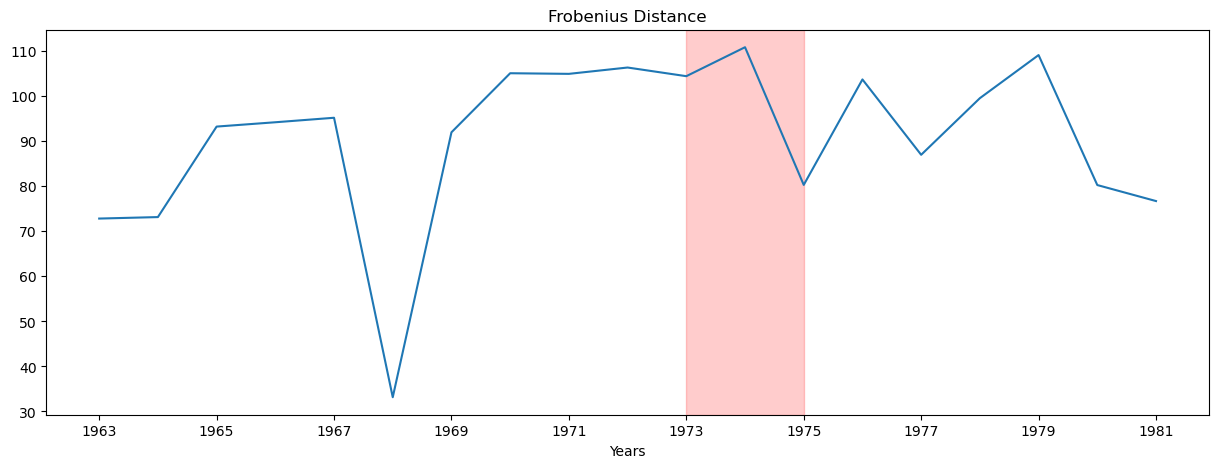

In [54]:
import matplotlib.pyplot as plt

# Create a range of x-values from 1962 to 1982 with a step of 2
plt.figure(figsize=(15, 5))
x = range(1963,1982)
range_values = list(range(1963, 1982, 2))
# Assuming 'y' is your y-axis data
plt.plot(x, frobenius_distances_oil)
plt.xticks(range_values)
plt.axvspan(1973, 1975, color='red', alpha=0.2)

plt.xlabel('Years')
plt.title('Frobenius Distance')

plt.show()

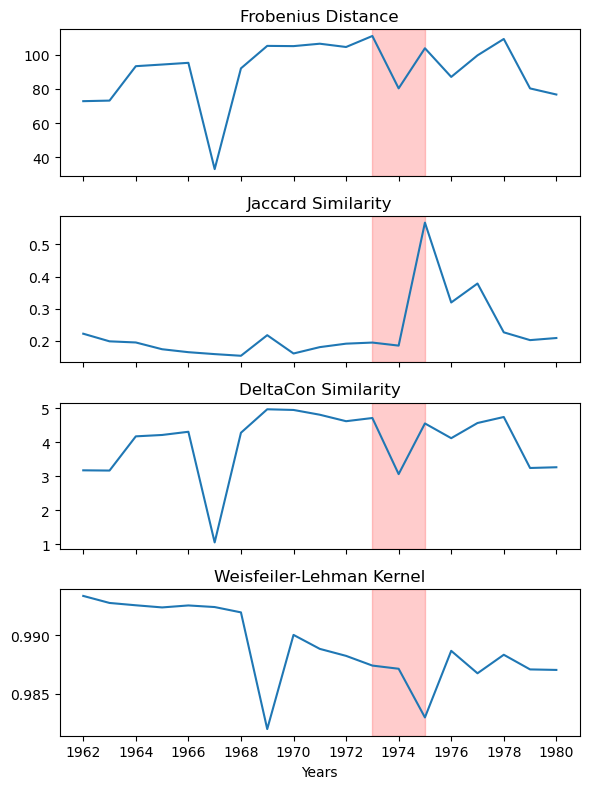

In [59]:
# Assuming 'x' is your common x-axis data and 'y1', 'y2', 'y3' are your y-axis data for the three lines
fig, axs = plt.subplots(4, sharex=True, figsize=(6, 8))

x = range(1962, 1981)
range_values = list(range(1962, 1981, 2))

axs[0].plot(x, frobenius_distances_oil)
axs[0].set_title('Frobenius Distance')
axs[0].set_xticks(range_values)
axs[0].axvspan(1973, 1975, color='red', alpha=0.2)

axs[1].plot(x, jaccard_distances_oil)
axs[1].set_title('Jaccard Similarity')
axs[1].set_xticks(range_values)
axs[1].axvspan(1973, 1975, color='red', alpha=0.2)

axs[2].plot(x, deltacon_distances_oil)
axs[2].set_title('DeltaCon Similarity')
axs[2].set_xticks(range_values)
axs[2].axvspan(1973, 1975, color='red', alpha=0.2)

axs[3].plot(x, wl_distances_oil)
axs[3].set_title('Weisfeiler-Lehman Kernel')
axs[3].set_xticks(range_values)
axs[3].axvspan(1973, 1975, color='red', alpha=0.2)

plt.xlabel('Years')
plt.tight_layout()
plt.show()

In [44]:
frobenius_distances = pairwise_distance(export_graphs, frobenius_distance)
frobenius_distances_imports = pairwise_distance(import_graphs, frobenius_distance)

/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/netrd/utilities/graph.py:118: RuntimeWarning: Coercing weighted graph to unweighted.
  warnings.warn("Coercing weighted graph to unweighted.", RuntimeWarning)


In [46]:
deltacon_distances_imports = pairwise_distance(import_graphs, deltacon_distance)
deltacon_distances_exports = pairwise_distance(export_graphs, deltacon_distance)

/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/netrd/utilities/graph.py:74: RuntimeWarning: Coercing directed graph to undirected.
  warnings.warn("Coercing directed graph to undirected.", RuntimeWarning)
<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [49]:
jaccard_distances_imports = pairwise_distance(import_graphs, jaccard_distance)
jaccard_distances_exports = pairwise_distance(export_graphs, jaccard_distance)

In [63]:
def create_heatmaps(export_distances, distance_name):
    # Create subplots
    years = range(1962,2022)
    fig, axs = plt.subplots(figsize=(5, 5))

    xlabels = [i if i % 5 == 0 else '' for i in years]  # change the step to your preference
    ylabels = [i if i % 5 == 0 else '' for i in years]  # change the step to your preference
    sns.heatmap(export_distances, ax=axs, cmap='YlGnBu', cbar=True, xticklabels=xlabels, yticklabels=ylabels)

    axs.set_xticklabels(xlabels, size='small')
    axs.set_yticklabels(ylabels, size='small')
    axs.set_title(f"{distance_name} for Exports")

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

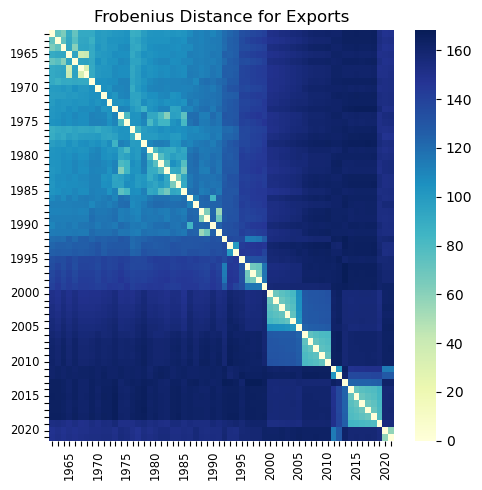

In [64]:
create_heatmaps(frobenius_distances, 'Frobenius Distance')

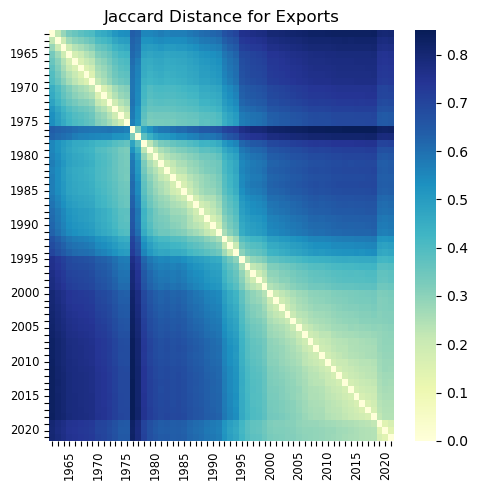

In [65]:
create_heatmaps(jaccard_distances_exports, 'Jaccard Distance')

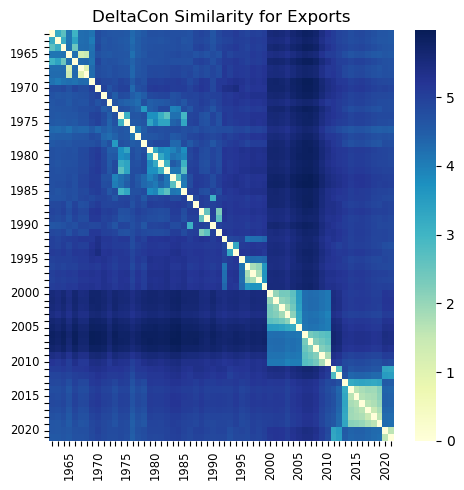

In [66]:
create_heatmaps(deltacon_distances_exports, 'DeltaCon Similarity')

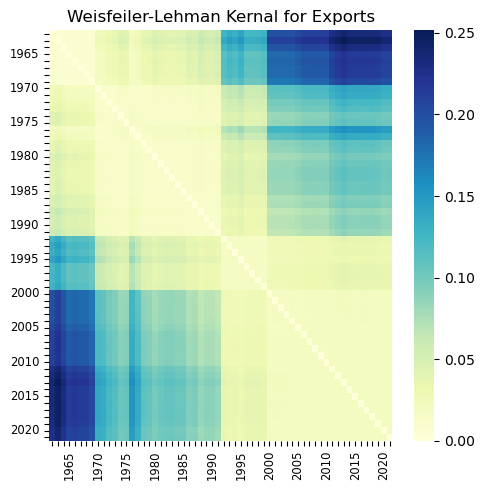

In [68]:
wl_matrix_exports = 1-wl_matrix_exports
wl_matrix_imports = 1-wl_matrix_imports
create_heatmaps(wl_matrix_exports, 'Weisfeiler-Lehman Kernal')

## Distances by Region

In [69]:
regions = locations['parent_id'].unique()
regions = regions[np.logical_and(~np.isnan(regions), regions != 358)]

### Exports

In [71]:
with open('../graphs/exports_agg.pkl', 'rb') as file:
    exports_agg = pkl.load(file)

In [72]:
regions_data_exports = []
for r in regions:
    trade_by_year = []
    for i in exports_agg:
        trade = i.merge(locations, left_on = "location_code", right_on = "location_code")
        trade.rename(columns = {"location_code_x":"location_code"}, inplace = True)
        trade_by_year.append(trade[trade['parent_id'] == r])
    regions_data_exports.append(trade_by_year)

In [73]:
regions_pivot_exports = []
for r in regions_data_exports:
    export_partners_region = []
    for i in r:
        df = i.pivot(index='location_code', columns='partner_code', values='export_value')
        df = df.fillna(0)
        export_partners_region.append(df)
    regions_pivot_exports.append(export_partners_region)

In [74]:
region_percents_exports = []
for r in regions_pivot_exports:
    export_percent = []
    for i in r:
        df = i.div(i.sum(axis=1), axis=0)
        export_percent.append(df)

    region_percents_exports.append(export_percent)

In [75]:
for r in region_percents_exports: 

    max_index = []
    max_len = len(r[0].index)
    for i in r:
        if len(i.index) > max_len:
            max_index = i.index

    for i in r:
        for j in max_index:
            if j not in i.columns:
                i[j] = 0
            if j not in i.index:
                i.loc[j] = 0

In [76]:
for r in region_percents_exports:  
   for i in r:
      index = i.index
      for j in index:
         if j not in i.columns:
            i[j] = 0

In [77]:
for r in region_percents_exports: 

    max_index = []
    max_len = len(r[0].index)
    for i in r:
        if len(i.index) > max_len:
            max_index = i.index

    for i in r:
        for j in max_index:
            if j not in i.index:
                i.loc[j] = 0
            if j not in i.columns:
                i[j] = 0

In [78]:
# Assuming 'dfs' is your list of DataFrames
for r in region_percents_exports:
    all_columns = pd.Index([])
    all_indices = pd.Index([])

    # Get the union of all columns and indices
    for df in r:
        all_columns = all_columns.union(df.columns)
        all_indices = all_indices.union(df.index)

    # Reindex each DataFrame
    for i in range(len(r)):
        r[i] = r[i].reindex(index=all_indices, columns=all_columns, fill_value=0)

In [79]:
exports_graphs_regions = []

for r in region_percents_exports:
    export_graphs = []
    for y in r:
        G = nx.from_pandas_adjacency(y, create_using=nx.DiGraph())
        export_graphs.append(G)
    exports_graphs_regions.append(export_graphs)

In [80]:
jaccard_regions_exports = []
for i in exports_graphs_regions:
    jaccard_regions_exports.append(pairwise_distance(i, jaccard_distance))

/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/netrd/utilities/graph.py:118: RuntimeWarning: Coercing weighted graph to unweighted.
  warnings.warn("Coercing weighted graph to unweighted.", RuntimeWarning)


In [81]:
frobenius_regions_exports = []
for i in exports_graphs_regions:
    frobenius_regions_exports.append(pairwise_distance(i, frobenius_distance))

In [82]:
deltacon_regions_exports = []
for i in exports_graphs_regions:
    deltacon_regions_exports.append(pairwise_distance(i, deltacon_distance))

/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/netrd/utilities/graph.py:74: RuntimeWarning: Coercing directed graph to undirected.
  warnings.warn("Coercing directed graph to undirected.", RuntimeWarning)
<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


KeyboardInterrupt: 

### Imports

In [38]:
with open('graphs/imports_agg.pkl', 'rb') as file:
    imports_agg = pkl.load(file)

In [129]:
regions_data_imports = []
for r in regions:
    trade_by_year = []
    for i in imports_agg:
        trade = i.merge(locations, left_on = "location_code", right_on = "location_code")
        trade.rename(columns = {"location_code_x":"location_code"}, inplace = True)
        trade_by_year.append(trade[trade['parent_id'] == r])
    regions_data_imports.append(trade_by_year)

In [130]:
regions_pivot_imports = []
for r in regions_data_imports:
    import_partners_region = []
    for i in r:
        df = i.pivot(index='location_code', columns='partner_code', values='import_value')
        df = df.fillna(0)
        import_partners_region.append(df)
    regions_pivot_imports.append(import_partners_region)

In [131]:
region_percents_imports = []
for r in regions_pivot_imports:
    import_percent = []
    for i in r:
        df = i.div(i.sum(axis=1), axis=0)
        import_percent.append(df)

    region_percents_imports.append(import_percent)

In [132]:
for r in region_percents_imports: 
    for i in r:
        index = i.index
        for j in index:
            if j not in i.columns:
                i[j] = 0
            if j not in i.index:
                i.loc[j] = 0

In [133]:
for r in region_percents_imports:  
   for i in r:
      index = i.index
      for j in index:
         if j not in i.columns:
            i[j] = 0

In [134]:
for r in region_percents_imports: 

    max_index = []
    max_len = len(r[0].index)
    for i in r:
        if len(i.index) > max_len:
            max_index = i.index

    for i in r:
        for j in max_index:
            if j not in i.index:
                i.loc[j] = 0

In [135]:
# Assuming 'dfs' is your list of DataFrames
for r in region_percents_imports:
    all_columns = pd.Index([])
    all_indices = pd.Index([])

    # Get the union of all columns and indices
    for df in r:
        all_columns = all_columns.union(df.columns)
        all_indices = all_indices.union(df.index)

    # Reindex each DataFrame
    for i in range(len(r)):
        r[i] = r[i].reindex(index=all_indices, columns=all_columns, fill_value=0)

In [136]:
imports_graphs_regions = []

for r in region_percents_imports:
    import_graphs = []
    for y in r:
        G = nx.from_pandas_adjacency(y, create_using=nx.DiGraph())
        import_graphs.append(G)
    imports_graphs_regions.append(import_graphs)

In [137]:
with open('region_graphs_imports.pkl', 'wb') as file:
    pkl.dump(imports_graphs_regions, file)

In [138]:
jaccard_regions_imports = []
for i in imports_graphs_regions:
    jaccard_regions_imports.append(pairwise_distance(i, jaccard_distance))

In [139]:
frobenius_regions_imports = []
for i in imports_graphs_regions:
    frobenius_regions_imports.append(pairwise_distance(i, frobenius_distance))

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_49911/2767284646.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  w1 = nx.adjacency_matrix(G1.to_undirected()).toarray()
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_49911/2767284646.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  w2 = nx.adjacency_matrix(G2.to_undirected()).toarray()


In [140]:
procrustes_regions_imports = []
for i in imports_graphs_regions:
    procrustes_regions_imports.append(pairwise_distance(i, procrustes_distance))

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_49911/3745436887.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.adjacency_matrix(G1).toarray()
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_49911/3745436887.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.adjacency_matrix(G2).toarray()


### Graphing

In [27]:
region_mappings = {354:'Oceania',
                   353:'Asia',
                   352:'Africa',
                   355:'Europe',
                   356:'North America',
                   357:'South America'}

In [29]:
region_labels = ['North America','Asia','Africa','Europe','South America','Oceania']

In [36]:
def create_heatmaps(distances, title):
    # Create subplots
    years = range(1962,2022)
    fig, axs = plt.subplots(3, 2, figsize=(10, 10))
    fig.suptitle(title)
    region_labels = ['North America','Asia','Africa','Europe','South America','Oceania']

    row = 0
    for j, i in enumerate(distances):
        # Plot the first heatmap
        column = 0
        if j % 2==1:
            column = 1
        if j == 2 or j==3:    
            row = 1
        if j == 4 or j == 5:
            row = 2

        xlabels = [i if i % 5 == 0 else '' for i in years]  # change the step to your preference
        ylabels = [i if i % 5 == 0 else '' for i in years]  # change the step to your preference
        sns.heatmap(i, ax=axs[row, column], cmap='YlGnBu', cbar=True, xticklabels=xlabels, yticklabels=ylabels)

        axs[row, column].set_xticklabels(xlabels, size='small')
        axs[row, column].set_yticklabels(ylabels, size='small')
        axs[row, column].set_title(region_labels[j])

    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Show the plot
    plt.show()

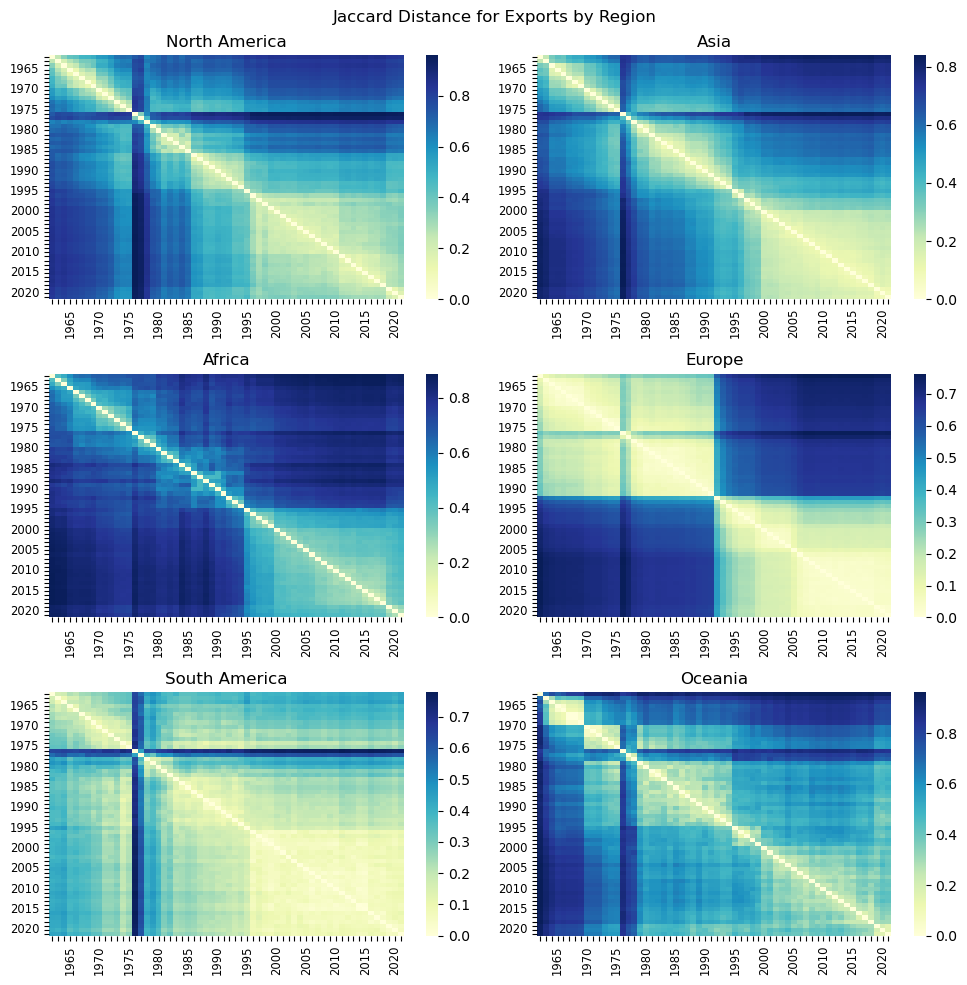

In [37]:
create_heatmaps(jaccard_regions_exports, 'Jaccard Distance for Exports by Region')

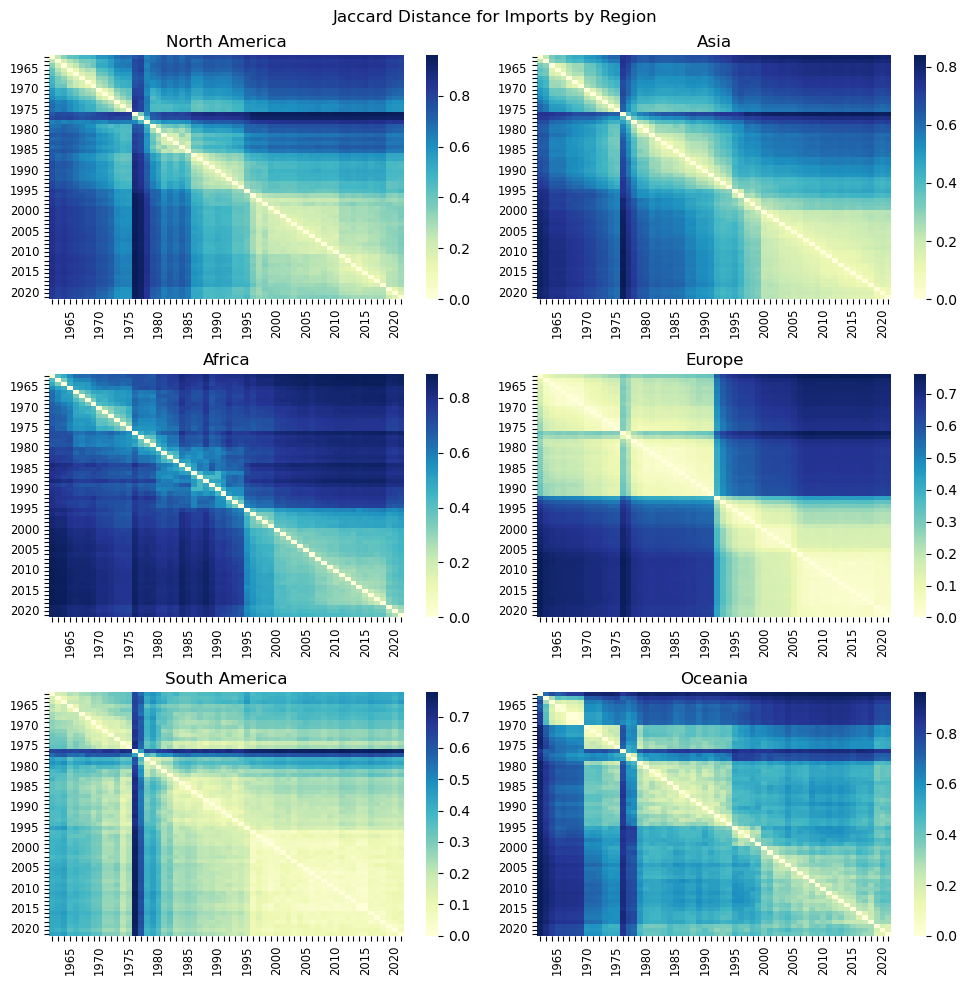

In [61]:
create_heatmaps(jaccard_regions_imports, 'Jaccard Distance for Imports by Region')

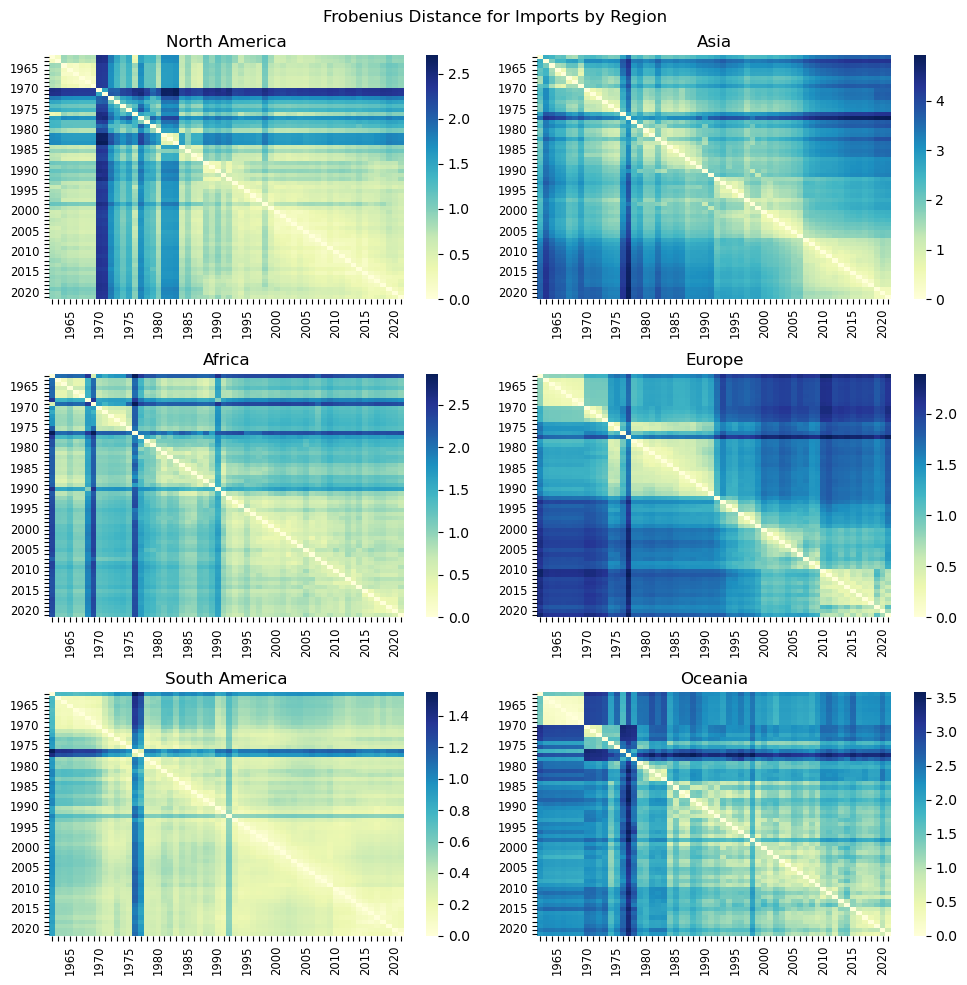

In [145]:
create_heatmaps(frobenius_regions_imports, 'Frobenius Distance for Imports by Region')

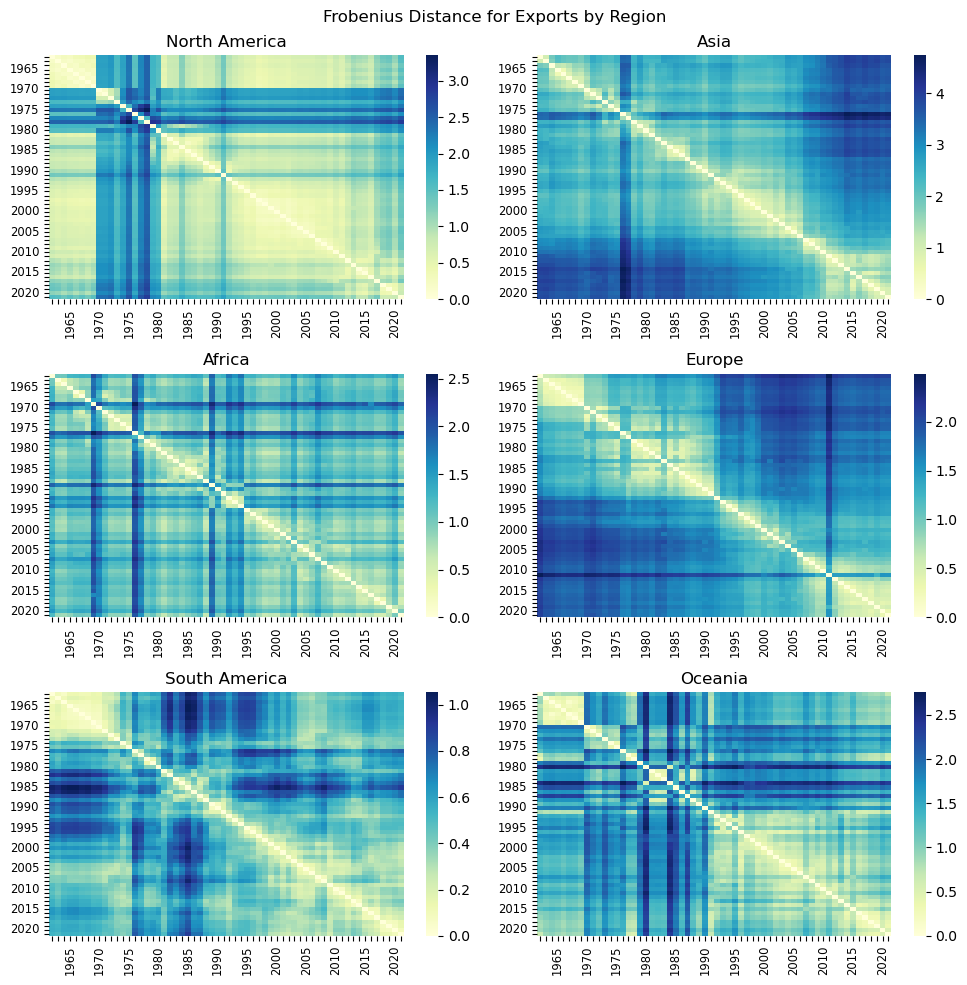

In [146]:
create_heatmaps(frobenius_regions_exports, 'Frobenius Distance for Exports by Region')

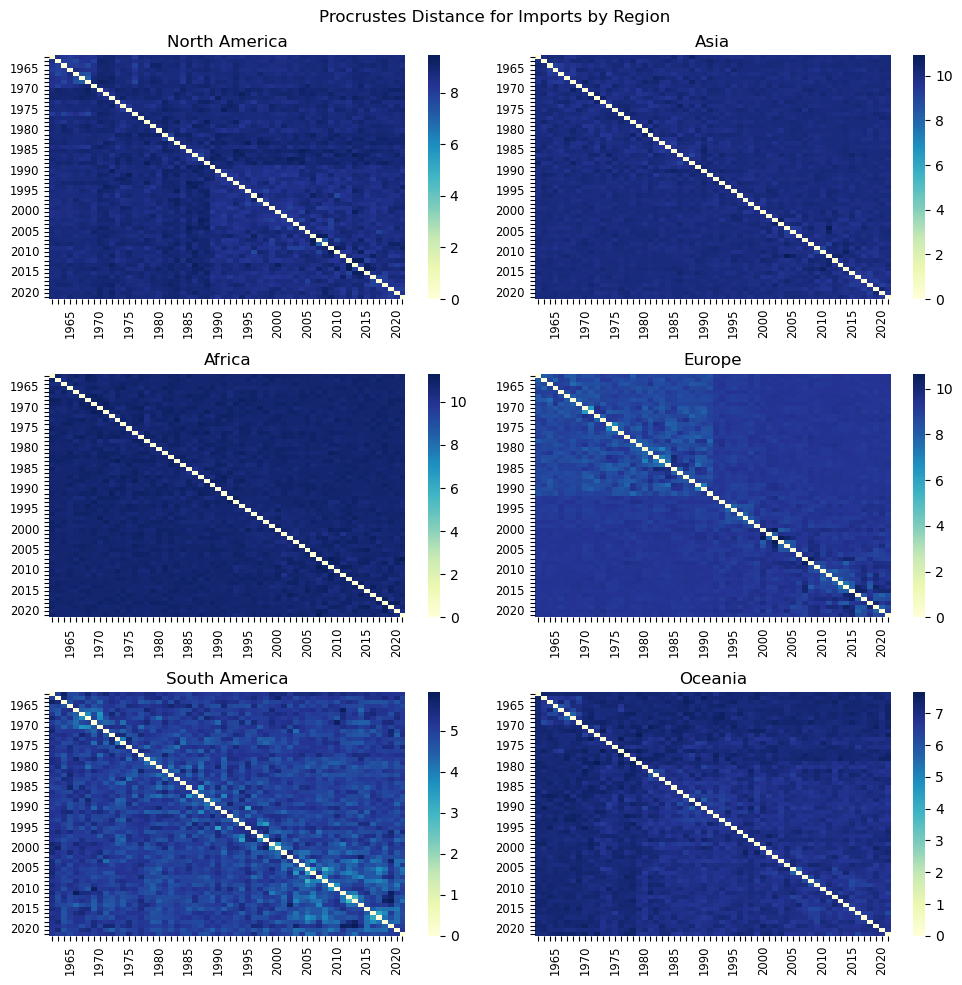

In [143]:
create_heatmaps(procrustes_regions_imports, 'Procrustes Distance for Imports by Region')

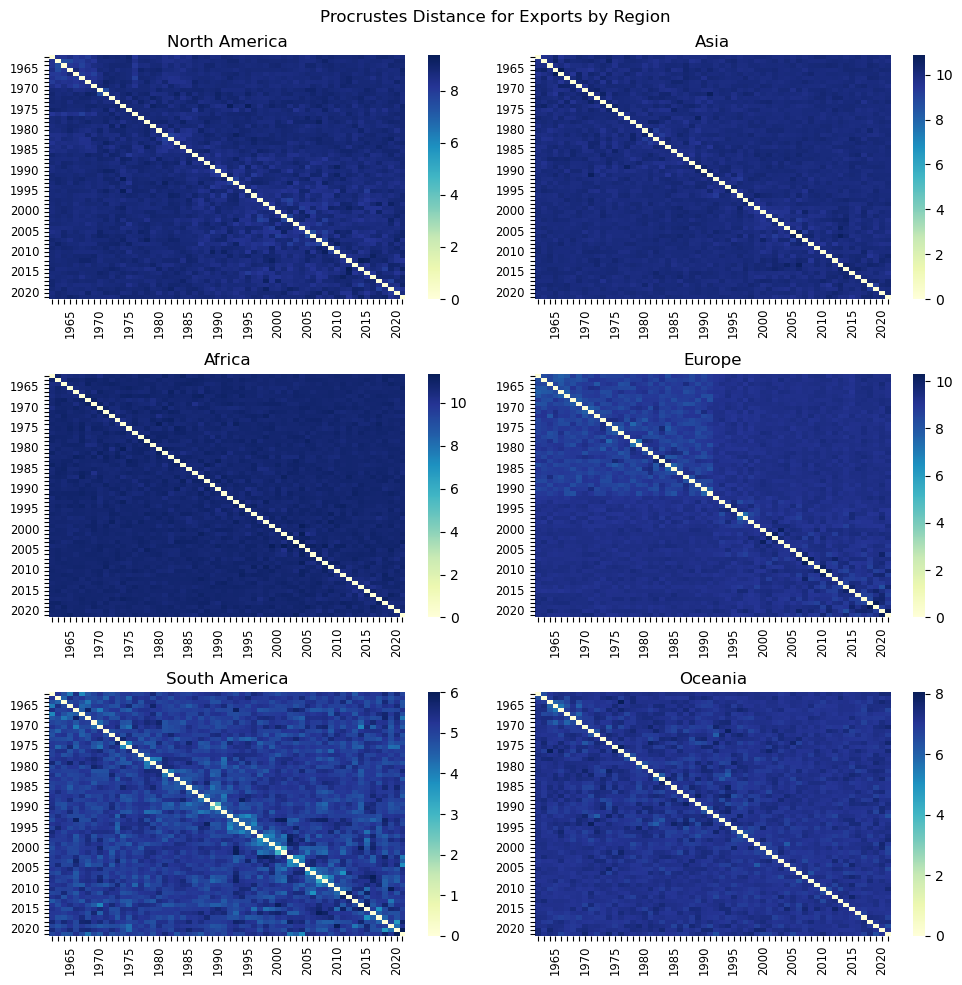

In [144]:
create_heatmaps(procrustes_regions_exports, 'Procrustes Distance for Exports by Region')

## Distances Grouped by Region

In [32]:
for r in regions:
    year_trade_exports = []
    for i in exports_agg:
        trade = i.merge(locations, left_on = "location_code", right_on = "location_code")
        trade.rename(columns = {"location_code_x":"location_code"}, inplace = True)
        trade = trade.merge(locations, left_on = "partner_code", right_on = "location_code")
        trade.rename(columns = {"location_code_x":"location_code","parent_id_x":"location_region","parent_id_y":"partner_region"}, inplace = True)
        trade.drop(columns = ["location_code_y"], inplace = True)
        trade = trade[trade['location_region'] != 358]
        trade = trade[trade['partner_region'] != 358]
        year_trade_exports.append(trade.groupby(["location_region","partner_region"])['export_value'].sum().reset_index())

In [33]:
export_agg_regions = []
for i in year_trade_exports:
    df = i.pivot(index='location_region', columns='partner_region', values='export_value')
    df = df.fillna(0)
    export_agg_regions.append(df)

In [34]:
export_agg_region_percent = []
for i in export_agg_regions:
    df = i.div(i.sum(axis=1), axis=0)
    export_agg_region_percent.append(df)

In [37]:
export_graphs_region_agg = []

for y in export_agg_region_percent:
    G = nx.from_pandas_adjacency(y, create_using=nx.DiGraph())
    export_graphs_region_agg.append(G)

In [39]:
for r in regions:
    year_trade_imports = []
    for i in imports_agg:
        trade = i.merge(locations, left_on = "location_code", right_on = "location_code")
        trade.rename(columns = {"location_code_x":"location_code"}, inplace = True)
        trade = trade.merge(locations, left_on = "partner_code", right_on = "location_code")
        trade.rename(columns = {"location_code_x":"location_code","parent_id_x":"location_region","parent_id_y":"partner_region"}, inplace = True)
        trade.drop(columns = ["location_code_y"], inplace = True)
        trade = trade[trade['location_region'] != 358]
        trade = trade[trade['partner_region'] != 358]
        year_trade_imports.append(trade.groupby(["location_region","partner_region"])['import_value'].sum().reset_index())

In [40]:
import_agg_regions = []
for i in year_trade_imports:
    df = i.pivot(index='location_region', columns='partner_region', values='import_value')
    df = df.fillna(0)
    import_agg_regions.append(df)

In [41]:
import_agg_region_percent = []
for i in import_agg_regions:
    df = i.div(i.sum(axis=1), axis=0)
    import_agg_region_percent.append(df)

In [42]:
import_graphs_region_agg = []

for y in import_agg_region_percent:
    G = nx.from_pandas_adjacency(y, create_using=nx.DiGraph())
    import_graphs_region_agg.append(G)

In [53]:
region_mappings = {354:'Oceania',
                   353:'Asia',
                   352:'Africa',
                   355:'Europe',
                   356:'North America',
                   357:'South America'}

In [64]:
for i, g in enumerate(export_graphs_region_agg):
    export_graphs_region_agg[i] = nx.relabel_nodes(g, region_mappings)

In [60]:
for i, g in enumerate(import_graphs_region_agg):
    import_graphs_region_agg[i] = nx.relabel_nodes(g, region_mappings)

In [66]:
jaccard_distances_imports_agg = pairwise_distance(import_graphs_region_agg, jaccard_distance)
jaccard_distances_exports_agg = pairwise_distance(export_graphs_region_agg, jaccard_distance)

In [67]:
frobenius_distances_imports_agg = pairwise_distance(import_graphs_region_agg, frobenius_distance)
frobenius_distances_exports_agg = pairwise_distance(export_graphs_region_agg, frobenius_distance)

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_74166/2767284646.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  w1 = nx.adjacency_matrix(G1.to_undirected()).toarray()
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_74166/2767284646.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  w2 = nx.adjacency_matrix(G2.to_undirected()).toarray()


In [68]:
procrustes_distances_imports_agg = pairwise_distance(import_graphs_region_agg, procrustes_distance)
procrustes_distances_exports_agg = pairwise_distance(export_graphs_region_agg, procrustes_distance)

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_74166/3745436887.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.adjacency_matrix(G1).toarray()
/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_74166/3745436887.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.adjacency_matrix(G2).toarray()


In [74]:
def create_heatmaps(import_distances, export_distances, distance_name):
    # Create subplots
    years = range(1962,2022)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"{distance_name} by Aggregated Region")

    xlabels = [i if i % 5 == 0 else '' for i in years]  # change the step to your preference
    ylabels = [i if i % 5 == 0 else '' for i in years]  # change the step to your preference
    sns.heatmap(import_distances, ax=axs[0], cmap='YlGnBu', cbar=True, xticklabels=xlabels, yticklabels=ylabels)

    axs[0].set_xticklabels(xlabels, size='small')
    axs[0].set_yticklabels(ylabels, size='small')
    axs[0].set_title(f"Imports")

    sns.heatmap(export_distances, ax=axs[1], cmap='YlGnBu', cbar=True, xticklabels=xlabels, yticklabels=ylabels)

    axs[1].set_xticklabels(xlabels, size='small')
    axs[1].set_yticklabels(ylabels, size='small')
    axs[1].set_title(f"Exports")

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

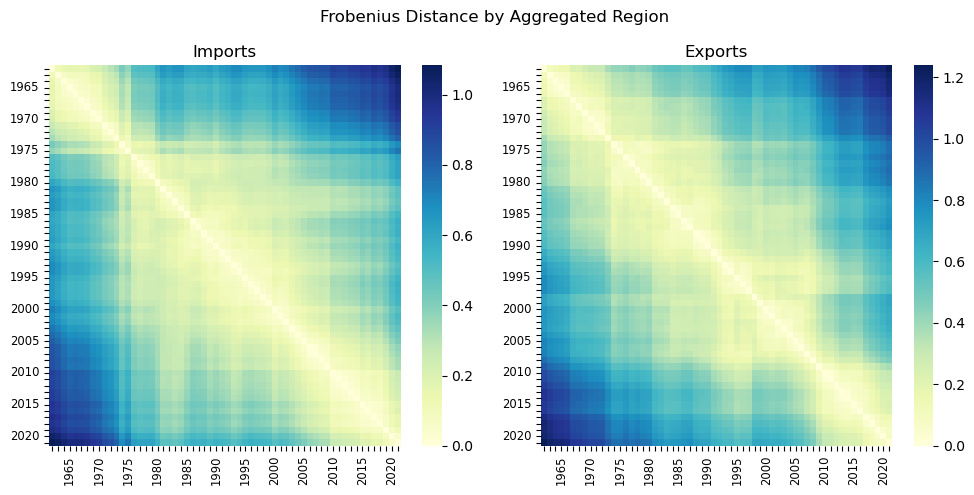

In [75]:
create_heatmaps(frobenius_distances_imports_agg, frobenius_distances_exports_agg, 'Frobenius Distance')

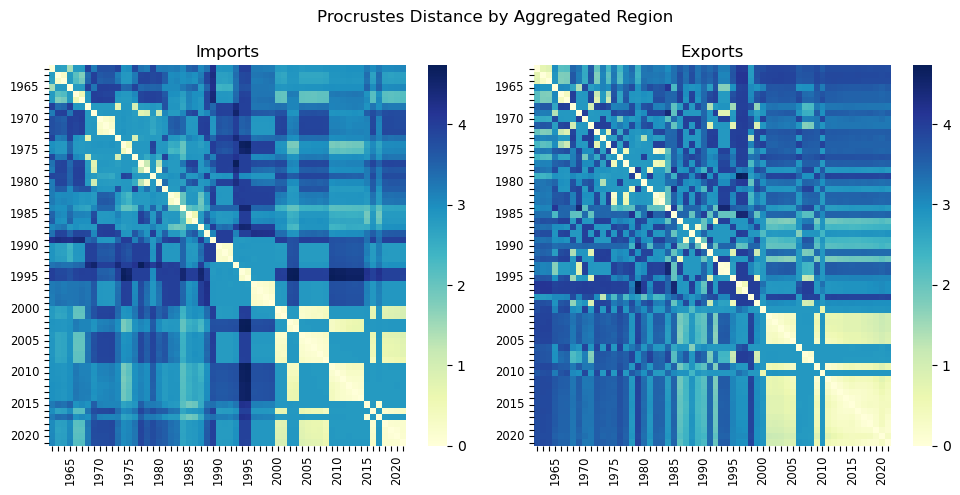

In [78]:
create_heatmaps(procrustes_distances_imports_agg, procrustes_distances_exports_agg, 'Procrustes Distance')

In [80]:
years = range(1962,2022)
for i, g in enumerate(import_graphs_region_agg):
    nx.set_edge_attributes(g, f'<[{years[i]}, {years[i]+1}]>', 'timeset')

In [96]:
graph_df = pd.DataFrame()
for i, g in enumerate(import_graphs_region_agg):
    graph_df = pd.concat([graph_df,nx.to_pandas_edgelist(g)], ignore_index=True)

In [97]:
graph_df = graph_df.rename(columns = {'source':'Source','target':'Target'})

In [98]:
graph_df.to_csv('imports_regions_agg.csv')